# TESTANDO MODELOS

In [44]:
# %pip install feature-engine

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [46]:
# FUNÇÃO PARA IDENTIFICAR PARES DE VARIÁVEIS COM ALTA CORRELAÇÃO

def identify_correlated_pairs(df, threshold=0.75):
    """
    Identifica pares de colunas com correlação alta em um DataFrame.
    
    Parâmetros:
    df (pd.DataFrame): DataFrame com as variáveis a serem analisadas.
    threshold (float): Valor de correlação mínima para considerar como alta.

    Retorna:
    list: Lista de tuplas com colunas e seus valores de correlação.
    """
    corr_matrix = df.corr().abs()
    
    # Obter os índices de correlações altas, exceto a diagonal principal
    high_corr_pairs = np.where((corr_matrix > threshold) & 
                               (np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
    
    # Obter os pares de colunas com correlação > threshold
    high_corr_list = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                      for x, y in zip(*high_corr_pairs)]
    
    return high_corr_list

In [47]:
# FUNÇÃO PARA TESTAR MODELOS SEM BALANCEAMENTO DE CLASSES

def evaluate_models(X_train, y_train, X_test, y_test):    
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
    from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
    import pandas as pd
    
    # Separando dados em folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Criando os modelos
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5),
        'XGBoost': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=2, learning_rate=0.2, loss_function='MultiClass', silent=True)
    }

    # Criar uma lista para armazenar os resultados
    results = []

    # Avaliando e treinando cada modelo
    for model_name, model in models.items():
        print(f"Avaliando modelo: {model_name}")

        # Avaliando o modelo com validação cruzada
        scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
        acuracia_treino = scores.mean()
        print("Scores de validação cruzada:", scores)
        print("Acurácia média de treino:", acuracia_treino)

        # Treinando o modelo e fazendo previsões
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Avaliar o modelo e coletar métricas
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy_teste = accuracy_score(y_test, y_pred)

        # Medição do Desempenho ROC_AUC_SCORE para múltiplas classes (One-vs-Rest)
        predicoes = model.predict_proba(X_test)
        roc_auc_score_test = roc_auc_score(y_test, predicoes, multi_class='ovr')

        # Adicionar as métricas ao DataFrame
        for class_label in report.keys():
            if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
                results.append({
                    'Modelo': model_name,
                    'Acurácia do Treino': acuracia_treino,
                    'Acurácia do Teste': accuracy_teste,
                    'ROC_AUC_SCORE': roc_auc_score_test,
                    'Classe': class_label,
                    'F1 Score': report[class_label]['f1-score'],
                    'Precisão': report[class_label]['precision'],
                    'Recall': report[class_label]['recall']
                })

        print("Relatório de classificação:")
        print(classification_report(y_test, y_pred))
        print("Acurácia do Teste:", accuracy_teste)
        print("Desempenho ROC/AUC:", roc_auc_score_test)
        print("-" * 50)  # Separador entre os modelos

    # Criar um DataFrame com os resultados
    results_df = pd.DataFrame(results)
    return results_df

In [48]:
# FUNÇÃO PARA TESTAR MODELOS SEM BALANCEAMENTO DE CLASSES

def evaluate_models_with_smote(X_train, y_train, X_test, y_test):
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
    from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
    from imblearn.over_sampling import SMOTE
    import pandas as pd
    # Separando dados em folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Criando os modelos
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5, class_weight='balanced'),
        'XGBoost': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=2, learning_rate=0.2, loss_function='MultiClass', silent=True)
    }

    # Aplicar SMOTE para sobreamostragem da classe minoritária
    smote = SMOTE(random_state=42)

    # Criar uma lista para armazenar os resultados
    results = []

    # Avaliando e treinando cada modelo
    for model_name, model in models.items():
        print(f"Avaliando modelo: {model_name}")
        
        # Aplicar SMOTE nos dados de treinamento
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Avaliando o modelo com validação cruzada
        scores = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring='accuracy')
        acuracia_treino = scores.mean()
        print("Scores de validação cruzada:", scores)
        print("Acurácia média de treino:", acuracia_treino)

        # Treinando o modelo e fazendo previsões
        model.fit(X_resampled, y_resampled)  # Treinando o modelo com os dados reamostrados
        y_pred = model.predict(X_test)  # Fazendo previsões

        # Avaliar o modelo e coletar métricas
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy_teste = accuracy_score(y_test, y_pred)

        # Medição do Desempenho ROC_AUC_SCORE
        predicoes = model.predict_proba(X_test)
        roc_auc_score_test = roc_auc_score(y_test, predicoes, multi_class='ovr', average='macro')

        # Adicionar as métricas ao DataFrame
        for class_label in report.keys():
            if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
                results.append({
                    'Modelo': model_name,
                    'Acurácia do Treino': acuracia_treino,
                    'Acurácia do Teste': accuracy_teste,
                    'ROC_AUC_SCORE': roc_auc_score_test,
                    'Classe': class_label,
                    'F1 Score': report[class_label]['f1-score'],
                    'Precisão': report[class_label]['precision'],
                    'Recall': report[class_label]['recall']
                })

        print("Relatório de classificação:")
        print(classification_report(y_test, y_pred))
        print("Acurácia do Teste:", accuracy_teste)
        print("Desempenho ROC/AUC:", roc_auc_score_test)
        print("-" * 50)  # Separador entre os modelos

    # Criar um DataFrame com os resultados
    results_df = pd.DataFrame(results)
    return results_df


In [49]:
# Load the datasets

pd.set_option('display.max_columns', 170)
pd.set_option('display.max_rows', 170)

df = pd.read_csv('bases/df_modelo.csv')

df.shape

(96502, 48)

In [50]:
df

,uf_ibge,classf,id_familia,cod_local_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_iluminacao_domic_fam,cod_familia_indigena_fam,ind_familia_quilombola_fam,ind_parc_mds_fam,qtde_pessoas,dias_cadastramento,dias_atualizacao,classe_renda,rf_idade,rf_trab_principal,rf_com_deficiencia,rf_trab_agricultura,rf_sexo,rf_curso_frequentou,rf_curso_frequenta,rf_trabalhou_semana,rf_cor_raca,rf_concluiu_curso,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca,pct_nao_alfabetizados,pct_n_freq_escola,pct_freq_publica,pct_freq_particular,pct_adulto_nunca_freq_escola,pct_escolar_nunca_freq_escola,pct_freq_creche,pct_idosos,pct_deficientes,pct_1_infancia,pct_adulto,pct_crianca_adolescente,fam_gpte,ideb_2017_municipio
0,42,2,268503,1.0,5.0,5.0,1.0,2.0,2.0,0.0,4,5128.0,102,0.0,38,6.0,2,1.0,2,4.0,-1.0,1.0,1.0,1.0,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.25,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.250000,0.5,0.0,6.3
1,29,3,2888440,2.0,2.0,2.0,1.0,2.0,2.0,0.0,2,2646.0,151,0.0,27,-1.0,2,-1.0,2,8.0,-1.0,2.0,4.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,5.1
2,35,3,2113517,1.0,5.0,5.0,1.0,2.0,2.0,0.0,2,5979.0,482,2.0,46,6.0,2,2.0,2,4.0,-1.0,1.0,4.0,1.0,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,5.7
3,33,2,4419096,1.0,3.0,5.0,1.0,2.0,2.0,0.0,2,238.0,238,0.0,34,-1.0,2,-1.0,2,8.0,-1.0,2.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,4.7
4,28,1,4241219,1.0,4.0,5.0,1.0,2.0,2.0,0.0,1,5500.0,17,0.0,56,-1.0,2,-1.0,2,5.0,-1.0,2.0,4.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96497,35,1,5181019,1.0,2.0,5.0,2.0,2.0,2.0,0.0,3,1643.0,438,0.0,25,1.0,2,2.0,2,8.0,-1.0,1.0,1.0,1.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,6.3
96498,23,2,3853705,1.0,2.0,5.0,6.0,2.0,2.0,0.0,2,479.0,479,0.0,18,-1.0,2,-1.0,2,5.0,-1.0,2.0,4.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,5.8
96499,29,3,1232994,1.0,6.0,5.0,1.0,2.0,2.0,0.0,2,843.0,836,2.0,68,-1.0,2,-1.0,1,-1.0,-1.0,2.0,4.0,-1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.50,0.0,0.000000,0.0,0.5,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,4.5
96500,31,3,1330889,1.0,5.0,5.0,1.0,2.0,2.0,0.0,3,2679.0,628,0.0,37,-1.0,2,-1.0,2,8.0,-1.0,2.0,4.0,2.0,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,6.2


In [51]:
#Checando os valores únicos das colunas
# Definindo as colunas a serem analisadas
columns_to_check = ['uf_ibge', 'classf', 'id_familia', 'cod_local_domic_fam',
       'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'cod_iluminacao_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam', 'qtde_pessoas',
       'dias_cadastramento', 'dias_atualizacao', 'rf_idade',
       'rf_trab_principal', 'rf_com_deficiencia', 'rf_trab_agricultura',
       'rf_sexo', 'rf_curso_frequentou', 'rf_curso_frequenta',
       'rf_trabalhou_semana', 'rf_cor_raca', 'rf_concluiu_curso',
       'pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escolar_nunca_freq_escola',
       'pct_freq_creche', 'pct_idosos', 'pct_deficientes', 'pct_1_infancia',
       'pct_adulto', 'pct_crianca_adolescente', 'fam_gpte',
       'ideb_2017_municipio'
]

# Criando um dicionário para armazenar os tipos de resposta
response_types = {}

# Iterando sobre as colunas e coletando os valores únicos
for column in columns_to_check:
    response_types[column] = df[column].unique()

# Exibindo os tipos de resposta de cada coluna
for column, unique_values in response_types.items():
    print(f"Coluna: {column}\nValores únicos: {unique_values}\n")

Coluna: uf_ibge
Valores únicos: [42 29 35 33 28 21 13 41 26 50 17 15 32 22 23 31 43 12 25 24 52 11 27 51
 16 14 53]

Coluna: classf
Valores únicos: [2 3 1]

Coluna: id_familia
Valores únicos: [ 268503 2888440 2113517 ... 1232994 1330889 1481101]

Coluna: cod_local_domic_fam
Valores únicos: [1. 2. 9.]

Coluna: qtd_comodos_domic_fam
Valores únicos: [ 5.  2.  3.  4. -1.  8.  6.  7.  9.  1. 10. 11. 12. 13. 15. 14. 16.  0.]

Coluna: cod_material_piso_fam
Valores únicos: [ 5.  2. -1.  4.  1.  3.  7.  6.]

Coluna: cod_iluminacao_domic_fam
Valores únicos: [ 1. -1.  2.  3.  6.  4.  5.]

Coluna: cod_familia_indigena_fam
Valores únicos: [2. 1.]

Coluna: ind_familia_quilombola_fam
Valores únicos: [2. 1.]

Coluna: ind_parc_mds_fam
Valores únicos: [  0.   9. 205. 301. 202. 204. 304. 201. 303. 305. 306. 101. 203. 302.]

Coluna: qtde_pessoas
Valores únicos: [ 4  2  1  3  5  9  6  8  7 10 11 12 13]

Coluna: dias_cadastramento
Valores únicos: [5128. 2646. 5979. ... 4109.  541. 5416.]

Coluna: dias_atual

In [52]:
# APLICANDO FUNÇÃO PARA IDENTIFICAR COLUNAS COM ALTA CORRELAÇÃO
high_corr_results = identify_correlated_pairs(df)
for col1, col2, corr_value in high_corr_results:
    print(f"Resultado: {col1} e {col2}, Correlação: {corr_value:.2f}")


Resultado: ind_parc_mds_fam e fam_gpte, Correlação: 0.82
Resultado: rf_trab_principal e rf_trabalhou_semana, Correlação: 0.77
Resultado: rf_com_deficiencia e pct_deficientes, Correlação: 0.84
Resultado: rf_trab_agricultura e rf_trabalhou_semana, Correlação: 0.80
Resultado: pct_nao_alfabetizados e pct_adulto_nunca_freq_escola, Correlação: 0.79
Resultado: pct_freq_publica e pct_crianca_adolescente, Correlação: 0.79


In [53]:
df

,uf_ibge,classf,id_familia,cod_local_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_iluminacao_domic_fam,cod_familia_indigena_fam,ind_familia_quilombola_fam,ind_parc_mds_fam,qtde_pessoas,dias_cadastramento,dias_atualizacao,classe_renda,rf_idade,rf_trab_principal,rf_com_deficiencia,rf_trab_agricultura,rf_sexo,rf_curso_frequentou,rf_curso_frequenta,rf_trabalhou_semana,rf_cor_raca,rf_concluiu_curso,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca,pct_nao_alfabetizados,pct_n_freq_escola,pct_freq_publica,pct_freq_particular,pct_adulto_nunca_freq_escola,pct_escolar_nunca_freq_escola,pct_freq_creche,pct_idosos,pct_deficientes,pct_1_infancia,pct_adulto,pct_crianca_adolescente,fam_gpte,ideb_2017_municipio
0,42,2,268503,1.0,5.0,5.0,1.0,2.0,2.0,0.0,4,5128.0,102,0.0,38,6.0,2,1.0,2,4.0,-1.0,1.0,1.0,1.0,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.25,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.250000,0.5,0.0,6.3
1,29,3,2888440,2.0,2.0,2.0,1.0,2.0,2.0,0.0,2,2646.0,151,0.0,27,-1.0,2,-1.0,2,8.0,-1.0,2.0,4.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,5.1
2,35,3,2113517,1.0,5.0,5.0,1.0,2.0,2.0,0.0,2,5979.0,482,2.0,46,6.0,2,2.0,2,4.0,-1.0,1.0,4.0,1.0,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,5.7
3,33,2,4419096,1.0,3.0,5.0,1.0,2.0,2.0,0.0,2,238.0,238,0.0,34,-1.0,2,-1.0,2,8.0,-1.0,2.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,4.7
4,28,1,4241219,1.0,4.0,5.0,1.0,2.0,2.0,0.0,1,5500.0,17,0.0,56,-1.0,2,-1.0,2,5.0,-1.0,2.0,4.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96497,35,1,5181019,1.0,2.0,5.0,2.0,2.0,2.0,0.0,3,1643.0,438,0.0,25,1.0,2,2.0,2,8.0,-1.0,1.0,1.0,1.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,6.3
96498,23,2,3853705,1.0,2.0,5.0,6.0,2.0,2.0,0.0,2,479.0,479,0.0,18,-1.0,2,-1.0,2,5.0,-1.0,2.0,4.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.500000,0.0,0.0,5.8
96499,29,3,1232994,1.0,6.0,5.0,1.0,2.0,2.0,0.0,2,843.0,836,2.0,68,-1.0,2,-1.0,1,-1.0,-1.0,2.0,4.0,-1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.50,0.0,0.000000,0.0,0.5,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,4.5
96500,31,3,1330889,1.0,5.0,5.0,1.0,2.0,2.0,0.0,3,2679.0,628,0.0,37,-1.0,2,-1.0,2,8.0,-1.0,2.0,4.0,2.0,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.00,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,6.2


In [54]:
df.columns

Index(['uf_ibge', 'classf', 'id_familia', 'cod_local_domic_fam',
       'qtd_comodos_domic_fam', 'cod_material_piso_fam',
       'cod_iluminacao_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam', 'qtde_pessoas',
       'dias_cadastramento', 'dias_atualizacao', 'classe_renda', 'rf_idade',
       'rf_trab_principal', 'rf_com_deficiencia', 'rf_trab_agricultura',
       'rf_sexo', 'rf_curso_frequentou', 'rf_curso_frequenta',
       'rf_trabalhou_semana', 'rf_cor_raca', 'rf_concluiu_curso',
       'pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escola

In [55]:
# conferindo variáveis

print(df.shape)


id_cols = ['id_familia', 'classe_renda']

binary_cols = ['cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
               'rf_com_deficiencia', 'rf_sexo', 'rf_trabalhou_semana', 'fam_gpte']  
multiclass_cols = ['uf_ibge', 'classf', 'cod_local_domic_fam',
       'cod_material_piso_fam', 'cod_iluminacao_domic_fam', 'ind_parc_mds_fam', 
       'rf_trab_principal', 'rf_trab_agricultura', 'rf_curso_frequentou', 'rf_curso_frequenta',
       'rf_cor_raca', 'rf_concluiu_curso'] 
numerical_cols = ['qtd_comodos_domic_fam', 'qtde_pessoas', 'rf_idade', 
       'dias_cadastramento', 'dias_atualizacao', 'ideb_2017_municipio'] 

percentage_cols = ['pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_militar_servidor',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'pct_trabalho_12meses_crianca', 'pct_nao_alfabetizados',
       'pct_n_freq_escola', 'pct_freq_publica', 'pct_freq_particular',
       'pct_adulto_nunca_freq_escola', 'pct_escolar_nunca_freq_escola',
       'pct_freq_creche', 'pct_idosos', 'pct_deficientes', 'pct_1_infancia',
       'pct_adulto', 'pct_crianca_adolescente']  

print(len(binary_cols) + len(multiclass_cols) + len(numerical_cols) + len(percentage_cols) + len(id_cols) )


(96502, 48)
48


In [56]:
print(len(binary_cols) + len(multiclass_cols))

categorical_cols = ['cod_familia_indigena_fam', 'ind_familia_quilombola_fam',
               'rf_com_deficiencia', 'rf_sexo', 'rf_trabalhou_semana', 'fam_gpte', 
               'uf_ibge', 'classf', 'cod_local_domic_fam', 'cod_material_piso_fam', 
               'cod_iluminacao_domic_fam', 'ind_parc_mds_fam', 'rf_trab_principal', 
               'rf_trab_agricultura', 'rf_curso_frequentou', 'rf_curso_frequenta',
               'rf_cor_raca', 'rf_concluiu_curso']

print(len(categorical_cols))

18
18


In [66]:
def preprocess_data(data, numerical_columns, categorical_columns):
    import pandas as pd
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    
    # Inicializar o StandardScaler para normalização das colunas numéricas
    scaler = StandardScaler()
    
    # Inicializar o OneHotEncoder para as colunas categóricas
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Criar um ColumnTransformer para aplicar as transformações
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler, numerical_columns),
            ('cat', encoder, categorical_columns)
        ],
        remainder='passthrough'  # Mantém as demais colunas
    )
    
    # Aplicar o preprocessor nos dados
    processed_data = preprocessor.fit_transform(data)
    
    # Obter nomes das colunas após a transformação
    column_names = (
        numerical_columns + 
        list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_columns)) +
        data.drop(columns=numerical_columns + categorical_columns).columns.tolist()  # Manter colunas não transformadas
    )
    
    # Criar um DataFrame com os dados transformados e os novos nomes das colunas
    processed_df = pd.DataFrame(processed_data, columns=column_names)
    
    return processed_df


In [67]:
print(f'Shape df: {df.shape}')

df_tratado = preprocess_data(df, numerical_cols, categorical_cols)

print(f'Shape df_tratado: {df_tratado.shape}')

df_tratado

Shape df: (96502, 48)
Shape df_tratado: (96502, 158)


,qtd_comodos_domic_fam,qtde_pessoas,rf_idade,dias_cadastramento,dias_atualizacao,ideb_2017_municipio,cod_familia_indigena_fam_1.0,cod_familia_indigena_fam_2.0,ind_familia_quilombola_fam_1.0,ind_familia_quilombola_fam_2.0,rf_com_deficiencia_1,rf_com_deficiencia_2,rf_sexo_1,rf_sexo_2,rf_trabalhou_semana_1.0,rf_trabalhou_semana_2.0,fam_gpte_0.0,fam_gpte_1.0,uf_ibge_11,uf_ibge_12,uf_ibge_13,uf_ibge_14,uf_ibge_15,uf_ibge_16,uf_ibge_17,uf_ibge_21,uf_ibge_22,uf_ibge_23,uf_ibge_24,uf_ibge_25,uf_ibge_26,uf_ibge_27,uf_ibge_28,uf_ibge_29,uf_ibge_31,uf_ibge_32,uf_ibge_33,uf_ibge_35,uf_ibge_41,uf_ibge_42,uf_ibge_43,uf_ibge_50,uf_ibge_51,uf_ibge_52,uf_ibge_53,classf_1,classf_2,classf_3,cod_local_domic_fam_1.0,cod_local_domic_fam_2.0,cod_local_domic_fam_9.0,cod_material_piso_fam_-1.0,cod_material_piso_fam_1.0,cod_material_piso_fam_2.0,cod_material_piso_fam_3.0,cod_material_piso_fam_4.0,cod_material_piso_fam_5.0,cod_material_piso_fam_6.0,cod_material_piso_fam_7.0,cod_iluminacao_domic_fam_-1.0,cod_iluminacao_domic_fam_1.0,cod_iluminacao_domic_fam_2.0,cod_iluminacao_domic_fam_3.0,cod_iluminacao_domic_fam_4.0,cod_iluminacao_domic_fam_5.0,cod_iluminacao_domic_fam_6.0,ind_parc_mds_fam_0.0,ind_parc_mds_fam_9.0,ind_parc_mds_fam_101.0,ind_parc_mds_fam_201.0,ind_parc_mds_fam_202.0,ind_parc_mds_fam_203.0,ind_parc_mds_fam_204.0,ind_parc_mds_fam_205.0,ind_parc_mds_fam_301.0,ind_parc_mds_fam_302.0,ind_parc_mds_fam_303.0,ind_parc_mds_fam_304.0,ind_parc_mds_fam_305.0,ind_parc_mds_fam_306.0,rf_trab_principal_-1.0,rf_trab_principal_1.0,rf_trab_principal_2.0,rf_trab_principal_3.0,rf_trab_principal_4.0,rf_trab_principal_5.0,rf_trab_principal_6.0,rf_trab_principal_7.0,rf_trab_principal_8.0,rf_trab_principal_9.0,rf_trab_principal_10.0,rf_trab_principal_11.0,rf_trab_agricultura_-1.0,rf_trab_agricultura_1.0,rf_trab_agricultura_2.0,rf_trab_agricultura_9.0,rf_curso_frequentou_-1.0,rf_curso_frequentou_1.0,rf_curso_frequentou_2.0,rf_curso_frequentou_3.0,rf_curso_frequentou_4.0,rf_curso_frequentou_5.0,rf_curso_frequentou_6.0,rf_curso_frequentou_7.0,rf_curso_frequentou_8.0,rf_curso_frequentou_9.0,rf_curso_frequentou_10.0,rf_curso_frequentou_11.0,rf_curso_frequentou_12.0,rf_curso_frequentou_13.0,rf_curso_frequentou_14.0,rf_curso_frequentou_15.0,rf_curso_frequenta_-1.0,rf_curso_frequenta_1.0,rf_curso_frequenta_3.0,rf_curso_frequenta_4.0,rf_curso_frequenta_5.0,rf_curso_frequenta_6.0,rf_curso_frequenta_7.0,rf_curso_frequenta_8.0,rf_curso_frequenta_9.0,rf_curso_frequenta_10.0,rf_curso_frequenta_11.0,rf_curso_frequenta_12.0,rf_curso_frequenta_13.0,rf_curso_frequenta_14.0,rf_cor_raca_1.0,rf_cor_raca_2.0,rf_cor_raca_3.0,rf_cor_raca_4.0,rf_cor_raca_5.0,rf_concluiu_curso_-1.0,rf_concluiu_curso_1.0,rf_concluiu_curso_2.0,id_familia,classe_renda,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca,pct_nao_alfabetizados,pct_n_freq_escola,pct_freq_publica,pct_freq_particular,pct_adulto_nunca_freq_escola,pct_escolar_nunca_freq_escola,pct_freq_creche,pct_idosos,pct_deficientes,pct_1_infancia,pct_adulto,pct_crianca_adolescente
0,0.481519,0.960055,-0.222978,1.366547,-0.984939,0.904952,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,268503.0,0.0,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.25,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.250000,0.5
1,-1.214667,-0.454288,-0.919676,0.120215,-0.830769,-0.327666,0.0,1.0,0.0,1

In [68]:
df_tratado['classe_renda'].value_counts()

classe_renda
0.0    56373
1.0    20597
2.0    19532
Name: count, dtype: int64

In [69]:
# separate train and test sets
print(f'Shape df_tratado: {df_tratado.shape}')

X = df_tratado.drop(labels=['classe_renda', 'id_familia'], axis=1)
y = df_tratado['classe_renda']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f'Shape X_train: {X_train.shape}')

print(f'Shape y_train: {y_train.shape}')

print(f'Shape X_test: {X_test.shape}')

print(f'Shape y_test: {y_test.shape}')

X_train.shape, X_test.shape

Shape df_tratado: (96502, 158)
Shape X_train: (67551, 156)
Shape y_train: (67551,)
Shape X_test: (28951, 156)
Shape y_test: (28951,)


((67551, 156), (28951, 156))

In [70]:
# FUNÇÃO PARA TESTAR MODELOS SEM BALANCEAMENTO DE CLASSES

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import pandas as pd

# Separando dados em folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Criando os modelos
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5),
    'XGBoost': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=2, learning_rate=0.2, loss_function='MultiClass', silent=True)
}

# Criar uma lista para armazenar os resultados
results = []

# Avaliando e treinando cada modelo
for model_name, model in models.items():
    print(f"Avaliando modelo: {model_name}")

    # Avaliando o modelo com validação cruzada
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    acuracia_treino = scores.mean()
    print("Scores de validação cruzada:", scores)
    print("Acurácia média de treino:", acuracia_treino)

    # Treinando o modelo e fazendo previsões
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Avaliar o modelo e coletar métricas
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy_teste = accuracy_score(y_test, y_pred)

    # Medição do Desempenho ROC_AUC_SCORE para múltiplas classes (One-vs-Rest)
    predicoes = model.predict_proba(X_test)
    roc_auc_score_test = roc_auc_score(y_test, predicoes, multi_class='ovr')

    # Adicionar as métricas ao DataFrame
    for class_label in report.keys():
        if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
            results.append({
                'Modelo': model_name,
                'Acurácia do Treino': acuracia_treino,
                'Acurácia do Teste': accuracy_teste,
                'ROC_AUC_SCORE': roc_auc_score_test,
                'Classe': class_label,
                'F1 Score': report[class_label]['f1-score'],
                'Precisão': report[class_label]['precision'],
                'Recall': report[class_label]['recall']
            })

    print("Relatório de classificação:")
    print(classification_report(y_test, y_pred))
    print("Acurácia do Teste:", accuracy_teste)
    print("Desempenho ROC/AUC:", roc_auc_score_test)
    print("-" * 50)  # Separador entre os modelos

# Criar um DataFrame com os resultados
results_df = pd.DataFrame(results)


Avaliando modelo: Random Forest
Scores de validação cruzada: [0.78913478 0.78712065 0.79378238 0.78911917 0.78697261]
Acurácia média de treino: 0.7892259195443513
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87     16912
         1.0       0.65      0.49      0.56      6179
         2.0       0.77      0.73      0.75      5860

    accuracy                           0.79     28951
   macro avg       0.75      0.71      0.73     28951
weighted avg       0.78      0.79      0.78     28951

Acurácia do Teste: 0.7896100307415979
Desempenho ROC/AUC: 0.9038492099260581
--------------------------------------------------
Avaliando modelo: XGBoost
Scores de validação cruzada: [0.79727629 0.79585492 0.80029608 0.79437454 0.7945966 ]
Acurácia média de treino: 0.7964796850289654
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.88     16912
      

In [ ]:
# # PRIMEIRA RODADA, ACHANADO HIPERPARÂMETROS

# from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Separando dados em folds
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Dicionário de modelos com hiperparâmetros para otimização
# models = {
#     'Random Forest': (RandomForestClassifier(), {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [10, 20, 30],
#         'min_samples_split': [2, 5, 10]
#     }),
#     'XGBoost': (XGBClassifier(eval_metric='logloss'), {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [3, 6, 10],
#         'learning_rate': [0.01, 0.1, 0.2]
#     }),
#     'CatBoost': (CatBoostClassifier(silent=True), {
#         'iterations': [100, 200],
#         'depth': [4, 6, 10],
#         'learning_rate': [0.01, 0.1, 0.2]
#     })
# }

# # Avaliando e treinando cada modelo
# for model_name, (model, param_grid) in models.items():
#     print(f"Avaliando modelo: {model_name}")
    
#     # Ajuste de hiperparâmetros com GridSearchCV
#     grid_search = GridSearchCV(model, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
    
#     # Melhor estimador encontrado e seus parâmetros
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     print(f"Melhores parâmetros para {model_name}: {best_params}")
    
#     # Avaliando o modelo com validação cruzada usando os melhores parâmetros
#     scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')
#     print("Scores de validação cruzada:", scores)
#     print("Acurácia média:", scores.mean())
    
#     # Treinando o modelo com os melhores parâmetros e fazendo previsões
#     best_model.fit(X_train, y_train)  # Treinando o modelo
#     y_pred = best_model.predict(X_test)  # Fazendo previsões
    
#     # Avaliar o modelo
#     print("Relatório de classificação:")
#     print(classification_report(y_test, y_pred))
#     print("Acurácia:", accuracy_score(y_test, y_pred))
#     print("-" * 50)  # Separador entre os modelos


In [22]:
df_resultados = evaluate_models(X_train, y_train, X_test, y_test)
#results_df.to_csv('resultados_modelo/estimao1.csv', index=False)

Avaliando modelo: Random Forest
Scores de validação cruzada: [0.79039301 0.79222798 0.78985936 0.79178386 0.78712065]
Acurácia média de treino: 0.7902769741966973
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87     16905
         1.0       0.65      0.49      0.56      6176
         2.0       0.77      0.72      0.75      5870

    accuracy                           0.79     28951
   macro avg       0.75      0.71      0.73     28951
weighted avg       0.78      0.79      0.78     28951

Acurácia do Teste: 0.788228385893406
Desempenho ROC/AUC: 0.9032163137397444
--------------------------------------------------
Avaliando modelo: XGBoost
Scores de validação cruzada: [0.79853453 0.79755736 0.79348631 0.79570688 0.79267209]
Acurácia média de treino: 0.7955914354622143
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87     16905
       

In [24]:
df_resultados_smote = evaluate_models_with_smote(X_train, y_train, X_test, y_test)
#df_resultados_smote.to_csv('resultados_modelo/estimao1_smote.csv', index=False)

Avaliando modelo: Random Forest
Scores de validação cruzada: [0.85460918 0.85650944 0.8555382  0.85021747 0.85329392]
Acurácia média de treino: 0.8540336412644646
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87     16905
         1.0       0.62      0.54      0.58      6176
         2.0       0.76      0.74      0.75      5870

    accuracy                           0.79     28951
   macro avg       0.74      0.72      0.73     28951
weighted avg       0.78      0.79      0.78     28951

Acurácia do Teste: 0.7872612344996719
Desempenho ROC/AUC: 0.9009703438294162
--------------------------------------------------
Avaliando modelo: XGBoost
Scores de validação cruzada: [0.8424053  0.84472784 0.84308095 0.83885816 0.84113176]
Acurácia média de treino: 0.8420408017546283
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87     16905
      

In [35]:
# separate train and test sets
print(f'Shape df: {df_tratado.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    df_tratado.drop(labels=['classe_renda', 'id_familia'], axis=1),
    df_tratado['classe_renda'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

Shape df: (96502, 127)


((67551, 125), (28951, 125))

### fazendo feature selection método recursivo

In [36]:
# removendo constante, quase constante e duplicadas features

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train)

# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

((67551, 102), (28951, 102))

In [37]:
# the ML model for which we want to select features

model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

# Setup the RFE selector

# Create a custom scorer for multi-class AUC
auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
#auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = auc_scorer, # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=2, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train, y_train)



c:\Users\miche\Desktop\Boootcamp_Machine_Learning\Projeto_Final\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


RecursiveFeatureElimination(cv=2,
                            estimator=GradientBoostingClassifier(max_depth=2,
                                                                 n_estimators=10,
                                                                 random_state=10),
                            scoring=make_scorer(roc_auc_score, response_method='predict_proba', multi_class=ovr),
                            threshold=0.0005)

In [44]:
# performance of model trained using all features

auc_inicial = sel.initial_model_performance_
auc_inicial

0.8458923951898578

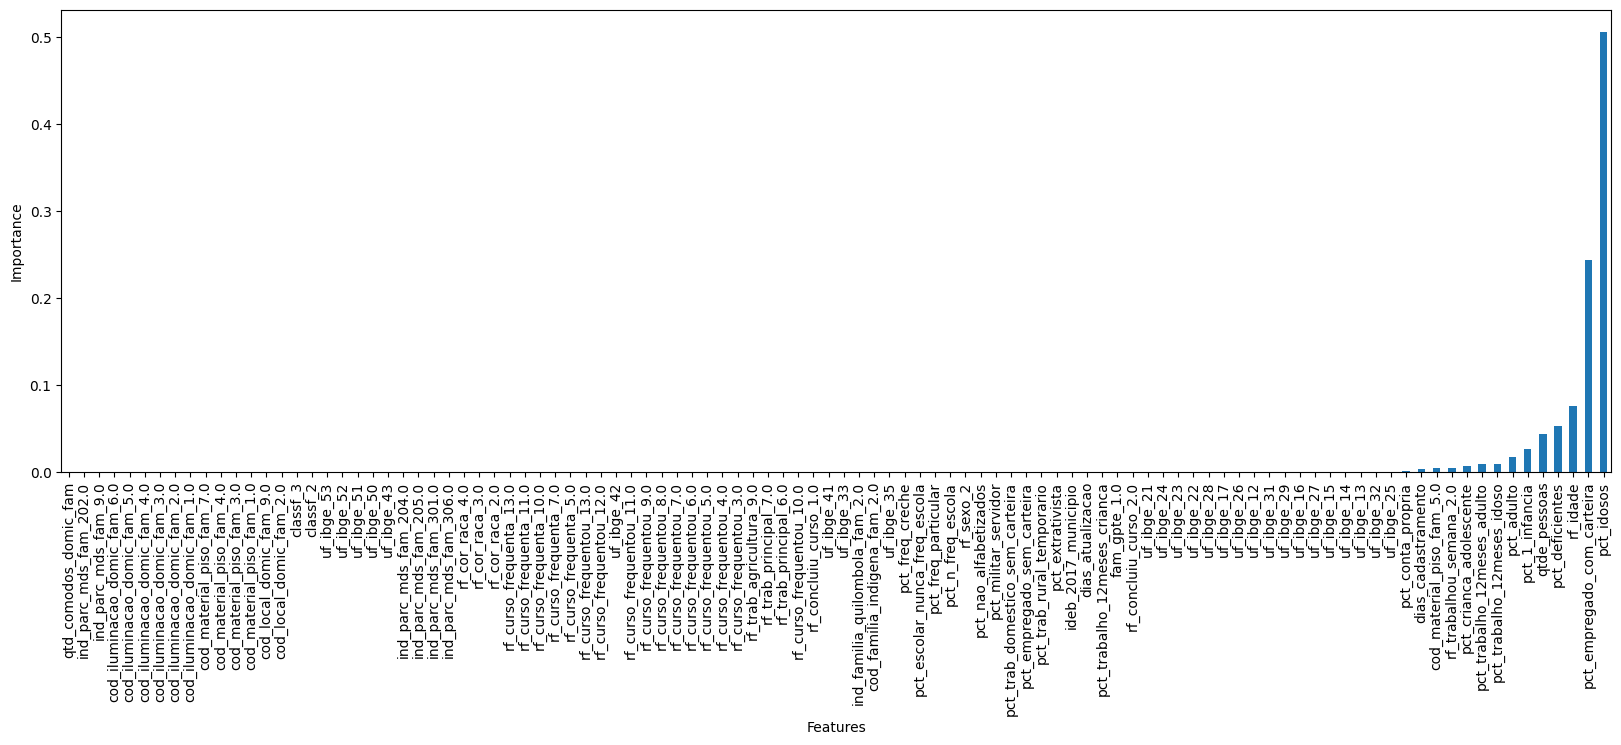

In [39]:
# importance of all features based of initial model

""" gráfico mostra a importância relativa de cada variável no modelo.
um valor maior indica que a feature tem um impacto mais significativo 
na previsão do modelo."""

sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

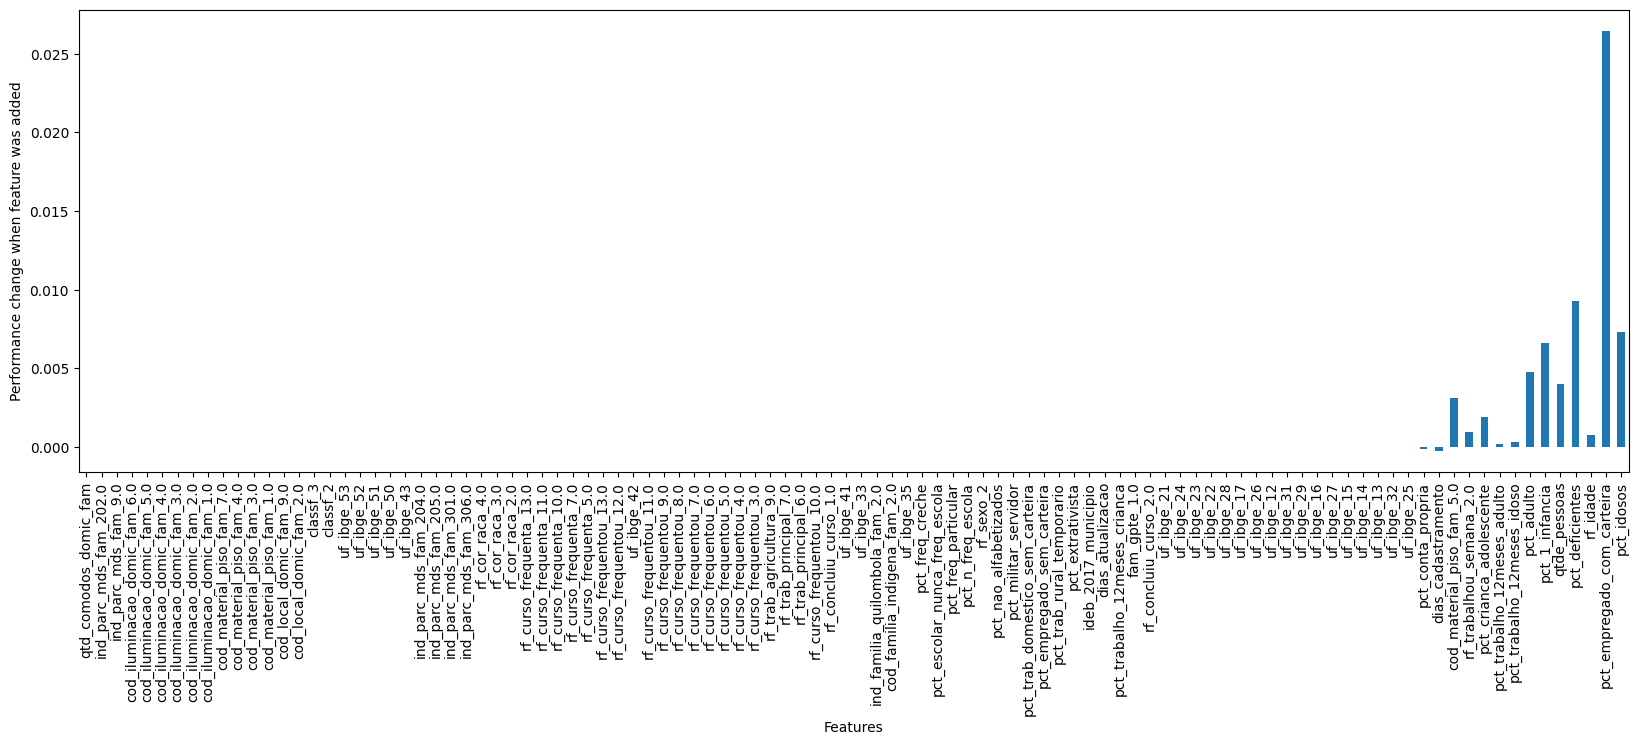

In [40]:
# mudança de performance do modelo quando uma feature é adicionada

"""o gráfico mostra a mudança de performance do modelo quando uma feature é adicionada.
um valor positivo indica que a feature tem um impacto positivo na previsão do modelo,
enquanto o valor negativo indica que a inclusão da feature pode degradar a performance 
do modelo."""

pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [41]:
# Number of features that will be removed

print(f'Shape antes: {df_tratado.shape}')

print(f'Features removidas: {len(sel.features_to_drop_)}')

# select features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape


Shape antes: (96502, 127)
Features removidas: 92


((67551, 10), (28951, 10))

In [46]:
X_train.columns

Index(['qtde_pessoas', 'rf_idade', 'pct_empregado_com_carteira', 'pct_idosos',
       'pct_deficientes', 'pct_1_infancia', 'pct_adulto',
       'pct_crianca_adolescente', 'rf_trabalhou_semana_2.0',
       'cod_material_piso_fam_5.0'],
      dtype='object')

In [45]:
from sklearn.metrics import roc_auc_score

# Fit the model with the selected features
model.fit(X_train, y_train)

# Make predictions
y_pred_test = model.predict_proba(X_test)

# Calculate ROC AUC for multi-class
roc_final = roc_auc_score(y_test, y_pred_test, multi_class='ovr')
print('Initial ROC AUC=%f' % (auc_inicial))
print('Test selected features ROC AUC=%f' % (roc_final))


Initial ROC AUC=0.845892
Test selected features ROC AUC=0.841165


In [47]:
# ANALISANDO MODELOS COM AS MELHORES COLUNAS
cols_use = ['classe_renda', 'qtde_pessoas', 'rf_idade', 'pct_empregado_com_carteira', 'pct_idosos',
       'pct_deficientes', 'pct_1_infancia', 'pct_adulto',
       'pct_crianca_adolescente', 'rf_trabalhou_semana_2.0',
       'cod_material_piso_fam_5.0']

# Deletar as colunas
df1 = df_tratado[cols_use]
df1

,classe_renda,qtde_pessoas,rf_idade,pct_empregado_com_carteira,pct_idosos,pct_deficientes,pct_1_infancia,pct_adulto,pct_crianca_adolescente,rf_trabalhou_semana_2.0,cod_material_piso_fam_5.0
0,0.0,0.250000,0.206897,0.0,0.0,0.0,0.250000,0.250000,0.5,0.0,1.0
1,0.0,0.083333,0.112069,0.0,0.0,0.0,0.500000,0.500000,0.0,1.0,0.0
2,2.0,0.083333,0.275862,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,1.0
3,0.0,0.083333,0.172414,0.0,0.0,0.0,0.500000,0.500000,0.0,1.0,1.0
4,0.0,0.000000,0.362069,0.0,0.0,0.0,0.000000,1.000000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
96497,0.0,0.166667,0.094828,0.0,0.0,0.0,0.666667,0.333333,0.0,0.0,1.0
96498,0.0,0.083333,0.034483,0.0,0.0,0.0,0.500000,0.500000,0.0,1.0,1.0
96499,2.0,0.083333,0.465517,0.0,1.0,0.0,0.000000,0.000000,0.0,1.0,1.0
96500,0.0,0.166667,0.198276,0.0,0.0,0.0,0.333333,0.666667,0.0,1.0,1.0


In [48]:
# separate train and test sets
print(f'Shape df: {df1.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(labels=['classe_renda'], axis=1),
    df1['classe_renda'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

Shape df: (96502, 11)


((67551, 10), (28951, 10))

In [49]:
# analisando modelos com as melhores colunas
df_resultados_smote = evaluate_models_with_smote(X_train, y_train, X_test, y_test)


Avaliando modelo: Random Forest
Scores de validação cruzada: [0.73337275 0.73784891 0.73548414 0.73324606 0.73619088]
Acurácia média de treino: 0.7352285477038839
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81     16905
         1.0       0.47      0.48      0.48      6176
         2.0       0.64      0.72      0.68      5870

    accuracy                           0.71     28951
   macro avg       0.65      0.66      0.65     28951
weighted avg       0.71      0.71      0.71     28951

Acurácia do Teste: 0.7081275258194881
Desempenho ROC/AUC: 0.8347703218671526
--------------------------------------------------
Avaliando modelo: XGBoost
Scores de validação cruzada: [0.7227313  0.7290655  0.72602508 0.72323804 0.72419764]
Acurácia média de treino: 0.725051511318231
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83     16905
       